In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def discriminator(input, input_feature, reuse = False):
    
    with tf.variable_scope("discriminator",reuse=reuse):
        
        with tf.name_scope("layer_1"):
            
            input_features = input_feature
            w1 = tf.get_variable('weights1', [input_features, 128], initializer=tf.random_normal_initializer(stddev=0.02))
            b1 = tf.get_variable('biases1', [128],initializer=tf.constant_initializer(0.0))
        
            pool1 = tf.reshape(input, [-1, input_features])
            fc1 = tf.nn.relu(tf.matmul(pool1, w1) + b1, name='relu')
            
        with tf.name_scope("layer_2"):
        
            w2 = tf.get_variable('weights2', [128, 1], initializer=tf.random_normal_initializer(stddev=0.02))
            b2 = tf.get_variable('biases2', [1],initializer=tf.constant_initializer(0.0))
        
            pool2 = tf.reshape(fc1, [-1, 128])
            fc2_logit = tf.matmul(pool2, w2) + b2
            fc2_prob = tf.sigmoid(fc2_logit)
            
    return fc2_logit, fc2_prob

def generator(input, input_feature, reuse = False):
    
    with tf.variable_scope("generator", reuse = reuse):

        with tf.name_scope("layer_1"):
            
            input_features = input_feature
            w = tf.get_variable('weights12', [input_features, 128], initializer=tf.random_normal_initializer(stddev=0.02))
            b = tf.get_variable('biases12', [128],initializer=tf.constant_initializer(0.0))
        
            pool = tf.reshape(input, [-1, input_features])
            fc11 = tf.nn.relu(tf.matmul(pool, w) + b, name='relu')
        
        with tf.name_scope("layer_2"):
        
            w2 = tf.get_variable('weights22', [128, 784], initializer=tf.random_normal_initializer(stddev=0.02))
            b2 = tf.get_variable('biases22', [784],initializer=tf.constant_initializer(0.0))
        
            pool2 = tf.reshape(fc11, [-1, 128])
            fc12 = tf.nn.sigmoid(tf.matmul(pool2, w2) + b2, name='relu')

    return fc12


X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
Z = tf.placeholder(tf.float32, [None, 100], name="Z_placeholder")

G = generator(Z, 100)
D_r_logit, D_r_prob = discriminator(X, 784)
D_f_logit, D_f_prob = discriminator(G, 784, reuse = True)

disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_r_logit, labels = tf.ones_like(D_r_logit)))
disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_f_logit, labels = tf.zeros_like(D_f_logit)))

disc_loss = disc_loss_real + disc_loss_fake

gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_f_logit, labels = tf.ones_like(D_f_logit)))

# Alternative loss
#disc_loss = -tf.reduce_mean(tf.log(D_r_prob) + tf.log(1. - D_f_prob))
#gen_loss = -tf.reduce_mean(tf.log(D_f_prob))

global_step = tf.Variable(0, name='global_step',trainable=False)

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
disc_step = tf.train.AdamOptimizer().minimize(disc_loss, var_list=t_vars[4:8])
gen_step = tf.train.AdamOptimizer().minimize(gen_loss, var_list=t_vars[0:4])

MNIST = input_data.read_data_sets("/data/mnist", one_hot=True)

BATCH_SIZE = 128
training_epochs = 100

k = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    initial_step = global_step.eval()
    
    for e in range(training_epochs):
        for ii in range(MNIST.train.num_examples//BATCH_SIZE):
          X_batch, Y_batch = MNIST.train.next_batch(BATCH_SIZE)
          Z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE,100))
          _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
          Z_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE,100))
          _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

        if (e+1)%10==0 or e == 0:
          samples = sess.run(G, feed_dict={Z: np.random.uniform(-1, 1, size=(16,100))})

          fig = plot(samples)
          plt.savefig('{}.png'.format(str(e).zfill(3)), bbox_inches='tight')
          k += 1
          plt.close(fig)

          print ("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(e,dloss,gloss))


tf.reset_default_graph()

Extracting /data/mnist/train-images-idx3-ubyte.gz
Extracting /data/mnist/train-labels-idx1-ubyte.gz
Extracting /data/mnist/t10k-images-idx3-ubyte.gz
Extracting /data/mnist/t10k-labels-idx1-ubyte.gz
Iterations: 0	 Discriminator loss: 0.1112	 Generator loss: 4.3588
Iterations: 9	 Discriminator loss: 0.3059	 Generator loss: 4.0534
Iterations: 19	 Discriminator loss: 0.6589	 Generator loss: 2.6669
Iterations: 29	 Discriminator loss: 0.6439	 Generator loss: 2.3569
Iterations: 39	 Discriminator loss: 0.9648	 Generator loss: 2.4370
Iterations: 49	 Discriminator loss: 0.7644	 Generator loss: 2.5114
Iterations: 59	 Discriminator loss: 0.7408	 Generator loss: 2.0389
Iterations: 69	 Discriminator loss: 0.9211	 Generator loss: 1.7510
Iterations: 79	 Discriminator loss: 1.0455	 Generator loss: 1.8690
Iterations: 89	 Discriminator loss: 0.7299	 Generator loss: 2.1590
Iterations: 99	 Discriminator loss: 0.7266	 Generator loss: 2.0074


Text(0.5, 1.0, 'Generated Images as epoch: 99')

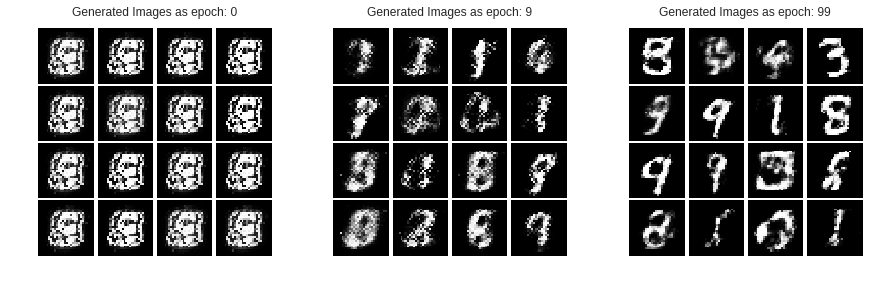

In [19]:
import imageio
img000 = imageio.imread('000.png')
img009 = imageio.imread('009.png')
img099 = imageio.imread('099.png')

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax1.imshow(img000)
ax1.axis('off')
ax1.set_title("Generated Images as epoch: 0")
ax2.imshow(img009)
ax2.axis('off')
ax2.set_title("Generated Images as epoch: 9")
ax3.imshow(img099)
ax3.axis('off')
ax3.set_title("Generated Images as epoch: 99")

In [0]:
!rm *.png